In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv("merged_factorio.csv")
print(df.shape)
df.head(3)

(728, 477)


,tick,time_s,pollution,buildings__boiler,buildings__offshore-pump,buildings__assembling-machine-1,buildings__burner-mining-drill,buildings__stone-furnace,buildings__electric-mining-drill,buildings__lab,...,M130_count,M131_state,M131_item,M131_count,M132_state,M132_item,M132_count,M133_state,M133_item,M133_count
0,1026000,17100,2112.483483,1,1,18,18.0,104,17,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1026000,17100,2112.471918,1,1,18,18.0,104,17,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1026000,17100,2112.483483,1,1,18,18.0,104,17,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# sayisal kolonlari bul
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# M count kolonlari (zaten sayisal)
m_count_cols = [c for c in df.columns if re.match(r"^M\d+_count$", c)]

# production ve buildings kolonlari
prod_cols = [c for c in df.columns if c.startswith("production__")]
bld_cols  = [c for c in df.columns if c.startswith("buildings__")]

core_cols = ["tick", "time_s", "logsim_power", "pollution", "logsim_pol_a", "logsim_pol_b", "logsim_pol_c"]
core_cols = [c for c in core_cols if c in df.columns]

use_cols = list(dict.fromkeys(core_cols + prod_cols + bld_cols + m_count_cols))  # unique
X = df[use_cols].copy()

# eksikleri doldur: once forward fill, sonra kalanlari 0
X = X.sort_values("tick")
X = X.ffill().fillna(0)

print("Using columns:", len(use_cols))
X.head(2)

Using columns: 164


,tick,time_s,logsim_power,pollution,logsim_pol_a,logsim_pol_b,logsim_pol_c,production__transport-belt,production__inserter,production__pipe,...,M124_count,M125_count,M126_count,M127_count,M128_count,M129_count,M130_count,M131_count,M132_count,M133_count
0,1026000,17100,0.0,2112.483483,0.0,0.0,0.0,56,17,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1026000,17100,0.0,2112.471918,0.0,0.0,0.0,56,17,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
target = "logsim_power"

corr = X.drop(columns=["tick", "time_s"], errors="ignore").corr(numeric_only=True)[target].sort_values(key=lambda s: s.abs(), ascending=False)
corr.head(20)

logsim_power    1.000000
M43_count       0.925363
M44_count       0.925214
M42_count       0.925202
M39_count       0.925047
M37_count       0.924799
M40_count       0.924710
M45_count       0.924674
M46_count       0.924666
M47_count       0.924628
M38_count       0.924612
M01_count       0.924441
M48_count       0.924295
M36_count       0.924277
M41_count       0.924042
M08_count       0.923535
M50_count       0.923211
M49_count       0.923166
M10_count       0.923164
M11_count       0.922978
Name: logsim_power, dtype: float64

In [2]:
import numpy as np
import pandas as pd
import re

df = pd.read_csv("merged_factorio.csv").sort_values("tick").reset_index(drop=True)

m_count_cols = [c for c in df.columns if re.match(r"^M\d+_count$", c)]
prod_cols = [c for c in df.columns if c.startswith("production__")]
bld_cols  = [c for c in df.columns if c.startswith("buildings__")]

core_cols = ["tick", "time_s", "logsim_power", "pollution", "logsim_pol_a", "logsim_pol_b", "logsim_pol_c"]
core_cols = [c for c in core_cols if c in df.columns]

use_cols = list(dict.fromkeys(core_cols + prod_cols + bld_cols + m_count_cols))
X = df[use_cols].copy()

feature_cols = [c for c in X.columns if c not in ["tick", "time_s"]]

# first valid index hesapla
first_valid = {c: X[c].first_valid_index() for c in feature_cols}

# avail dataframe'i tek seferde oluştur
avail_data = {}
n = len(X)
for c, idx in first_valid.items():
    if idx is None:
        avail_data[c + "__avail"] = np.zeros(n, dtype=int)
    else:
        a = np.zeros(n, dtype=int)
        a[idx:] = 1
        avail_data[c + "__avail"] = a

Avail = pd.DataFrame(avail_data)

# tek concat ile ekle + defrag
X = pd.concat([X, Avail], axis=1).copy()

# Dataset A ve B
A = X.ffill().fillna(0)

stable_start = max([idx for idx in first_valid.values() if idx is not None], default=0)
B = A.iloc[stable_start:].copy()

print("Full A rows:", len(A), "start tick:", int(A["tick"].iloc[0]))
print("Stable B rows:", len(B), "start tick:", int(B["tick"].iloc[0]))

Full A rows: 728 start tick: 1026000
Stable B rows: 81 start tick: 3308400


In [3]:
import numpy as np
import pandas as pd

A = A.copy()  # sende zaten var

# sayisal featurelar (avail flag haric)
num_feats = [c for c in A.columns if c not in ["tick", "time_s"] and not c.endswith("__avail")]

corr = A[num_feats].corr(numeric_only=True)["logsim_power"].sort_values(key=lambda s: s.abs(), ascending=False)
top20 = [c for c in corr.index if c != "logsim_power"][:20]

core_set = ["logsim_power", "pollution", "logsim_pol_a", "logsim_pol_b", "logsim_pol_c"] + top20
core_set = [c for c in core_set if c in A.columns]

# Bu core set'in stabil başlangıcı: her kolonun first valid index'inin max'ı
orig = df[["tick"] + [c for c in core_set if c in df.columns]].sort_values("tick").reset_index(drop=True)
core_first_valid = {c: orig[c].first_valid_index() for c in core_set}
core_stable_start = max([i for i in core_first_valid.values() if i is not None], default=0)

B_core = A.iloc[core_stable_start:].copy()

print("Core stable rows:", len(B_core), "start tick:", int(B_core["tick"].iloc[0]))
print("Top 20 features:", top20)

Core stable rows: 370 start tick: 2268000
Top 20 features: ['M43_count', 'M44_count', 'M42_count', 'M39_count', 'M37_count', 'M40_count', 'M45_count', 'M46_count', 'M47_count', 'M38_count', 'M01_count', 'M48_count', 'M36_count', 'M41_count', 'M08_count', 'M50_count', 'M49_count', 'M10_count', 'M11_count', 'M22_count']


Anomalies (|z|>3): 14


,tick,logsim_power,power_z
358,2268000,90000.0,4.800000
359,2271600,90000.0,3.322650
394,2397600,67703.0,-3.073230
398,2412000,36522.0,-3.183144
464,2649600,68441.0,4.002529
465,2653200,68254.0,3.020391
466,2656800,91400.0,3.459883
467,2660400,99929.0,3.009280
523,2862000,97951.0,3.813833
524,2865600,118149.0,3.777424


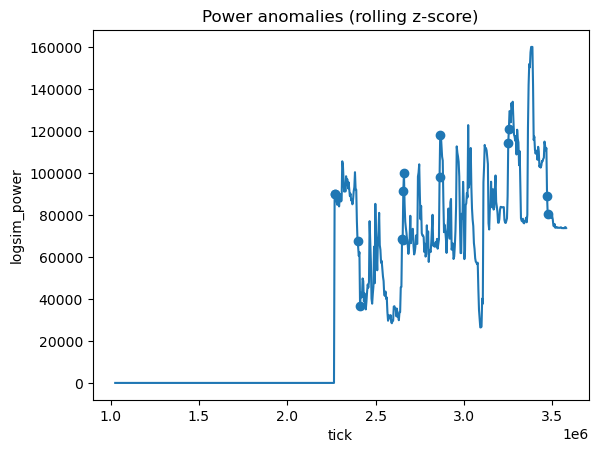

In [4]:
import matplotlib.pyplot as plt

s = A["logsim_power"].astype(float)
w = 25

mu = s.rolling(w, min_periods=w).mean()
sd = s.rolling(w, min_periods=w).std()
z = (s - mu) / (sd + 1e-9)

A["power_z"] = z
anoms = A.loc[z.abs() > 3, ["tick", "logsim_power", "power_z"]].copy()

print("Anomalies (|z|>3):", len(anoms))
display(anoms.head(15))

plt.figure()
plt.plot(A["tick"], A["logsim_power"])
plt.scatter(anoms["tick"], anoms["logsim_power"])
plt.xlabel("tick")
plt.ylabel("logsim_power")
plt.title("Power anomalies (rolling z-score)")
plt.show()

C:\Users\aysen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


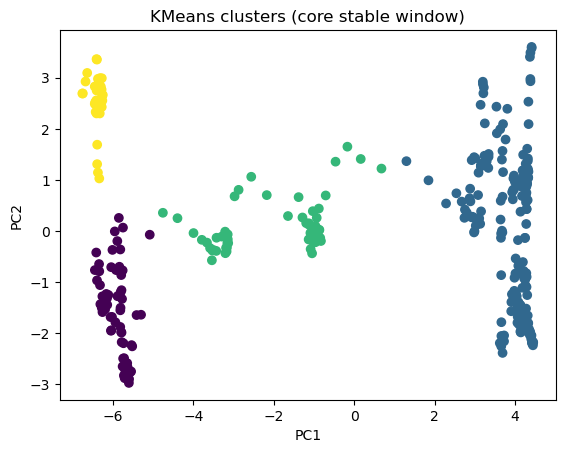

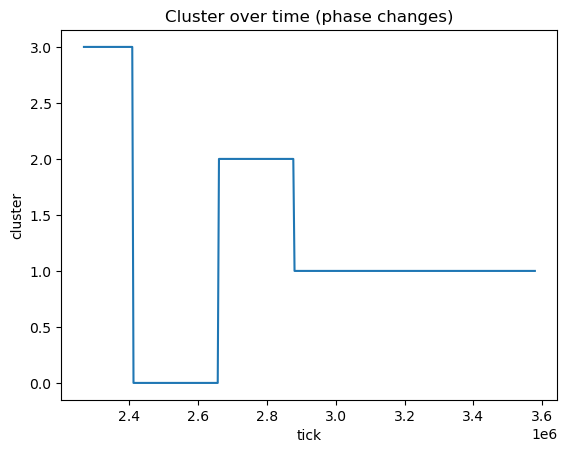

,tick,cluster,logsim_power,pollution
358,2268000,3,90000.0,10283.864837
359,2271600,3,90000.0,10349.259889
360,2275200,3,90000.0,10453.894862
361,2278800,3,86776.0,10592.845583
362,2282400,3,84867.0,10687.475502
363,2286000,3,84841.0,10768.877400
364,2289600,3,88596.0,10858.779522
365,2293200,3,84050.0,10892.766955
366,2296800,3,87647.0,10962.966996
367,2300400,3,89925.0,11064.029619


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

feat = core_set  # bir önceki hücrede çıktı
M = B_core[feat].copy()

scaler = StandardScaler()
Ms = scaler.fit_transform(M)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Ms)
B_core["cluster"] = labels

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Ms)

plt.figure()
plt.scatter(Z[:,0], Z[:,1], c=labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans clusters (core stable window)")
plt.show()

plt.figure()
plt.plot(B_core["tick"], B_core["cluster"])
plt.xlabel("tick")
plt.ylabel("cluster")
plt.title("Cluster over time (phase changes)")
plt.show()

B_core[["tick", "cluster", "logsim_power", "pollution"]].head(10)